In [13]:
#Usual Imports
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np
import pandas as pd


In [14]:
# path to the Million Song Subset (Uncompressed)
msd_subset_path = 'MillionSongSubset'
msd_subset_data_path =os.path.join(msd_subset_path, "data")
msd_subset_addf_path=os.path.join(msd_subset_path,"additionalfiles")
assert os.path.isdir(msd_subset_path), "wrong path"# sanity check
assert os.path.isdir(msd_subset_data_path), "wrong path"# sanity check
assert os.path.isdir(msd_subset_addf_path), "wrong path"# sanity check
msd_code_path="MSongsDB"
assert os.path.isdir(msd_code_path), "wrong path"
sys.path.append(os.path.join(msd_code_path,"PythonSrc"))

In [15]:
# imports specific to the MSD
import hdf5_getters as GETTERS

In [16]:
def strtimedelta(starttime,stoptime):
    return str(datetime.timedelta(seconds=stoptime-starttime))

In [17]:
#Import the song and artist data from SQL
conn = sqlite3.connect(os.path.join(msd_subset_addf_path,"subset_track_metadata.db"))
q= "SELECT * FROM songs"
song_data=pd.read_sql(q, conn)
conn.close()
song_data.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,TRACCVZ128F4291A8A,Deep Sea Creature,SOVLGJY12A8C13FBED,Call of the Mastodon,ARMQHX71187B9890D3,bc5e2ad6-0a4a-4d90-b911-e9a7e6861727,Mastodon,280.21506,0.780462,0.574275,2001
1,TRACCMH128F428E4CD,No Quieras Marcharte,SOGDQZK12A8C13F37C,Adelante,AR2PT4M1187FB55B1A,d54ea4a6-0b9c-4e47-bed0-289ae9ff4037,Los Chichos,191.68608,0.561590,0.420570,1984
2,TRACCSW128F148C7C3,If I...,SODMVJR12A6D4F985D,Ill Na Na,ARDI88R1187B98DAB2,fd87374e-ffde-4d36-89a8-8a073f795666,Foxy Brown,222.92853,0.687687,0.406686,0
3,TRACCXJ128F428F0CF,Werther - Lyric Drama in four Acts/Act I/Alors...,SOIWBDR12A8C13A4AC,Massenet: Werther,ARUKJUP12086C14589,8a5f2736-bcde-4a2e-8d50-72631d66a7ef,Ramón Vargas;Vladimir Jurowski,278.38649,0.391741,0.291265,0
4,TRACCVS12903D014F8,Ad Te Clamamus Exsvles Mortva Liberi,SOHCCIA12AC907577F,Pentagrammaton,ARZEWUR1187FB53DC8,0be59867-0da4-4e45-9b64-728cdf25487c,Enthroned,89.15546,0.593416,0.395710,2010


In [20]:
#Import the artist similarity data from SQL
conn = sqlite3.connect(os.path.join(msd_subset_addf_path,"subset_artist_similarity.db"))
q= "SELECT * FROM artists"
similarity_data=pd.read_sql(q, conn)
conn.close()
similarity_data.head(10)

,artist_id
0,AR009211187B989185
1,AR00A6H1187FB5402A
2,AR00LNI1187FB444A5
3,AR00MBZ1187B9B5DB1
4,AR01IP11187B9AF5D2
5,AR01VU31187B997DA0
6,AR01W2D1187FB5912F
7,AR022JO1187B99587B
8,AR02DB61187B9A0B5E
9,AR02IU11187FB513F2


In [37]:
conn = sqlite3.connect(os.path.join(msd_subset_addf_path,"subset_track_metadata.db"))
q = "SELECT DISTINCT artist_name FROM songs"
t1= time.time()
res = conn.execute(q)
all_artist_names_sqlite=res.fetchall()
t2=time.time()
print("all artist names extracted (SQLite) in: ", strtimedelta(t1,t2))
conn.close()
for k in range(0,5):
    print (all_artist_names_sqlite[k][0])

all artist names extracted (SQLite) in:  0:00:00.008506
!!!
(hed) p.e.
089 Clique feat. Minnesota Snipe & Skinny Cueball
089 Clique feat. Prophet
1. Futurologischer Congress


,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,TRACCVZ128F4291A8A,Deep Sea Creature,SOVLGJY12A8C13FBED,Call of the Mastodon,ARMQHX71187B9890D3,bc5e2ad6-0a4a-4d90-b911-e9a7e6861727,Mastodon,280.21506,0.780462,0.574275,2001
1,TRACCMH128F428E4CD,No Quieras Marcharte,SOGDQZK12A8C13F37C,Adelante,AR2PT4M1187FB55B1A,d54ea4a6-0b9c-4e47-bed0-289ae9ff4037,Los Chichos,191.68608,0.561590,0.420570,1984
2,TRACCSW128F148C7C3,If I...,SODMVJR12A6D4F985D,Ill Na Na,ARDI88R1187B98DAB2,fd87374e-ffde-4d36-89a8-8a073f795666,Foxy Brown,222.92853,0.687687,0.406686,0
3,TRACCXJ128F428F0CF,Werther - Lyric Drama in four Acts/Act I/Alors...,SOIWBDR12A8C13A4AC,Massenet: Werther,ARUKJUP12086C14589,8a5f2736-bcde-4a2e-8d50-72631d66a7ef,Ramón Vargas;Vladimir Jurowski,278.38649,0.391741,0.291265,0
4,TRACCVS12903D014F8,Ad Te Clamamus Exsvles Mortva Liberi,SOHCCIA12AC907577F,Pentagrammaton,ARZEWUR1187FB53DC8,0be59867-0da4-4e45-9b64-728cdf25487c,Enthroned,89.15546,0.593416,0.395710,2010


In [53]:
len(song_data)

10000

In [23]:
#Subset the useful columns
song_useful = song_data[["title","release","artist_id","artist_name","duration", "artist_familiarity","artist_hotttnesss","year"]]

In [24]:
song_useful.head(15)

,title,release,artist_id,artist_name,duration,artist_familiarity,artist_hotttnesss,year
0,Deep Sea Creature,Call of the Mastodon,ARMQHX71187B9890D3,Mastodon,280.21506,0.780462,0.574275,2001
1,No Quieras Marcharte,Adelante,AR2PT4M1187FB55B1A,Los Chichos,191.68608,0.561590,0.420570,1984
2,If I...,Ill Na Na,ARDI88R1187B98DAB2,Foxy Brown,222.92853,0.687687,0.406686,0
3,Werther - Lyric Drama in four Acts/Act I/Alors...,Massenet: Werther,ARUKJUP12086C14589,Ramón Vargas;Vladimir Jurowski,278.38649,0.391741,0.291265,0
4,Ad Te Clamamus Exsvles Mortva Liberi,Pentagrammaton,ARZEWUR1187FB53DC8,Enthroned,89.15546,0.593416,0.395710,2010
5,Murder One,BTNHRESURRECTION,ARUZRFN1187B98AC05,Bone Thugs-N-Harmony,255.73832,0.815923,0.555138,2000
6,On My Feet Again,Utopia,ARHBWOZ1187FB3FD53,Utopia,239.59465,0.543937,0.430300,0
7,Bedroom Acoustics,Plug In Baby,ARR3ONV1187B9A2F59,Muse,156.96934,0.929030,0.750427,0
8,Segredo,Joao Voz E Violato,AR3THYK1187B999F1F,João Gilberto,197.19791,0.645192,0.471224,2000
9,Sajana (Ft Faheem Mazhar),The Lost Souls Bonus EP,ARFELOH1187B991F95,Niraj Chag,262.58240,0.495819,0.342765,0


In [25]:
# Find the 10 most common artists
popular_artists = song_useful.groupby(["artist_id","artist_name"]).size()
popular_artists.order(ascending=False).head(10)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: order is deprecated, use sort_values(...)
  app.launch_new_instance()


artist_id           artist_name              
AROIHOI122988FEB8E  Mario Rosenstock             13
ARIRD6J1187FB5A98C  Sugar Minott                 12
AR9W3X91187FB3994C  Phil Collins                 12
AR12F2S1187FB56EEF  Aerosmith                    12
AREWQSE1187B9AEC6C  The Jackson Southernaires    12
ARH6W4X1187B99274F  Radiohead                    11
AR78ZID1187B9B31ED  Mikey Dread                  11
ARODBRG1187FB3FD99  Nick Cave & The Bad Seeds    11
ARJIE2Y1187B994AB7  Line Renaud                  11
ARVN9FZ1187FB393F1  Snow Patrol                  11
dtype: int64

In [27]:
#rank the artists by "hotttnesss"
hot_artists = song_useful.groupby(["artist_id","artist_name", "artist_hotttnesss"]).size()
hotness_data=hot_artists.reset_index().sort("artist_hotttnesss",ascending=False)
hotness_data.columns=["artist_id","artist_name","artist_hotness","song_count"]
hotness_data.head(30)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,artist_id,artist_name,artist_hotness,song_count
3413,ARRH63Y1187FB47783,Kanye West,1.082503,6
3414,ARRH63Y1187FB47783,Kanye West / Adam Levine,1.082503,1
3415,ARRH63Y1187FB47783,Kanye West / Consequence / Cam'Ron,1.082503,1
3416,ARRH63Y1187FB47783,Kanye West / Lupe Fiasco,1.082503,1
1800,ARF8HTQ1187B9AE693,Daft Punk,1.021256,1
3670,ARTDQRC1187FB4EFD4,Black Eyed Peas / Terry Dexter,1.005942,1
3669,ARTDQRC1187FB4EFD4,Black Eyed Peas / Les Nubians / Mos Def,1.005942,1
3668,ARTDQRC1187FB4EFD4,Black Eyed Peas,1.005942,3
3505,ARS54I31187FB46721,Taylor Swift,0.922412,1
2311,ARJ7KF01187B98D717,Coldplay,0.916053,6


In [29]:
import matplotlib.pyplot as plt

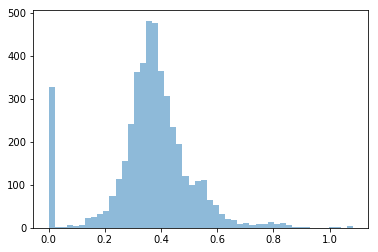

In [31]:
#hotttnesss distribution
plt.hist(hotness_data["artist_hotness"],bins=50, alpha=0.5)
plt.show()

In [32]:
years =  song_useful.groupby(["year"]).size()
years.reset_index().tail(10)
#plt.hist(years,bins=100)
#plt.show()
#Lots of rows with no year and the most recent is only 2010

,year,0
59,2001,217
60,2002,198
61,2003,254
62,2004,270
63,2005,304
64,2006,320
65,2007,285
66,2008,253
67,2009,250
68,2010,64


In [33]:
years[0]

5320

In [34]:
big_table=pd.read_csv("all_billboard_data.txt", sep="|", encoding='latin1')

In [35]:
big_table.head(10)

,pos,last week,peak,weeks on chart,title,artist,chart entry date,entry position,overall peak,overall weeks on chart,chart date
0,1,1,1.0,15.0,Uptown Funk!,MARK RONSON featuring BRUNO MARS,41972.0,65.0,1.0,15.0,20150307
1,2,2,2.0,20.0,Thinking Out Loud,ED SHEERAN,41937.0,69.0,2.0,20.0,20150307
2,3,6,3.0,7.0,Love Me Like You Do,ELLIE GOULDING,42028.0,45.0,3.0,7.0,20150307
3,4,5,4.0,6.0,Sugar,MAROON 5,42035.0,8.0,4.0,6.0,20150307
4,5,3,2.0,28.0,Take Me To Church,HOZIER,41881.0,96.0,2.0,28.0,20150307
5,6,4,4.0,5.0,FourFiveSeconds,RIHANNA & KANYE WEST & PAUL McCARTNEY,42042.0,54.0,4.0,5.0,20150307
6,7,7,1.0,17.0,Blank Space,TAYLOR SWIFT,41958.0,18.0,1.0,17.0,20150307
7,8,10,8.0,9.0,Style,TAYLOR SWIFT,42014.0,84.0,8.0,9.0,20150307
8,9,12,9.0,9.0,Earned It (Fifty Shades Of Grey),THE WEEKND,42014.0,49.0,9.0,9.0,20150307
9,10,9,4.0,18.0,Lips Are Movin',MEGHAN TRAINOR,41951.0,93.0,4.0,18.0,20150307


In [49]:
longest_single =big_table.groupby(["title","artist","overall weeks on chart"]).size()
longest_single.reset_index().sort("overall weeks on chart",ascending=False).head(20)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,title,artist,overall weeks on chart,0
24707,Radioactive,IMAGINE DRAGONS,85.0,85
15299,I'm Yours,JASON MRAZ,76.0,76
12647,How Do I Live,LeANN RIMES,69.0,69
5811,Counting Stars,ONEREPUBLIC,68.0,68
23739,Party Rock Anthem,LMFAO featuring LAUREN BENNETT & GOONROCK,67.0,67
9178,Foolish Games / You Were Meant For Me,JEWEL,65.0,15
37030,You Were Meant For Me / Foolish Games,JEWEL,65.0,50
25564,Rolling In The Deep,ADELE,64.0,64
3144,Before He Cheats,CARRIE UNDERWOOD,64.0,64
12201,Ho Hey,THE LUMINEERS,62.0,62
